# Sequence Models
<a id=part1></a>

In this part we will learn about working with text sequences using recurrent neural networks.
We'll go from a raw text file all the way to a fully trained GRU-RNN model and generate works of art!

In [4]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Text generation with a char-level RNN
<a id=part1_1></a>

### Obtaining the corpus
<a id=part1_2></a>

Downloading a corpus containing all the works of William Shakespeare.
This corpus is very large and will provide enough data for
obtaining impressive results.

In [6]:
CORPUS_URL = 'https://github.com/cedricdeboom/character-level-rnn-datasets/raw/master/datasets/shakespeare.txt'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_corpus(out_path=DATA_DIR, url=CORPUS_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))
    
    if os.path.isfile(out_filename) and not force:
        print(f'Corpus file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename
    
corpus_path = download_corpus()

Corpus file C:\Users\27nad\.pytorch-datasets\shakespeare.txt exists, skipping download.


Load the text into memory and print a snippet:

In [12]:
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f'Corpus length: {len(corpus)} chars')
print(corpus[7:1234])

Corpus length: 6347703 chars
ALLS WELL THAT ENDS WELL

by William Shakespeare

Dramatis Personae

  KING OF FRANCE
  THE DUKE OF FLORENCE
  BERTRAM, Count of Rousillon
  LAFEU, an old lord
  PAROLLES, a follower of Bertram
  TWO FRENCH LORDS, serving with Bertram

  STEWARD, Servant to the Countess of Rousillon
  LAVACHE, a clown and Servant to the Countess of Rousillon
  A PAGE, Servant to the Countess of Rousillon

  COUNTESS OF ROUSILLON, mother to Bertram
  HELENA, a gentlewoman protected by the Countess
  A WIDOW OF FLORENCE.
  DIANA, daughter to the Widow

  VIOLENTA, neighbour and friend to the Widow
  MARIANA, neighbour and friend to the Widow

  Lords, Officers, Soldiers, etc., French and Florentine  

SCENE:
Rousillon; Paris; Florence; Marseilles

ACT I. SCENE 1.
Rousillon. The COUNT'S palace

Enter BERTRAM, the COUNTESS OF ROUSILLON, HELENA, and LAFEU, all in black

  COUNTESS. In delivering my son from me, I bury a second husband.
  BERTRAM. And I in going, madam, weep o'er

### Data Preprocessing
<a id=part1_3></a>

Map from each unique character in the corpus to an index that will represent it in our learning process.

In [13]:
import modules.charnn as charnn

char_to_idx, idx_to_char = charnn.char_maps(corpus)
print(char_to_idx)

test.assertEqual(len(char_to_idx), len(idx_to_char))
test.assertSequenceEqual(list(char_to_idx.keys()), list(idx_to_char.values()))
test.assertSequenceEqual(list(char_to_idx.values()), list(idx_to_char.keys()))

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '_': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '}': 81, '\ufeff': 82}


I have some strange characters in the corpus that are very rare and are probably due to mistakes.
To reduce the length of each tensor I will need to later represent our chars, it's best to remove them.

In [14]:
corpus, n_removed = charnn.remove_chars(corpus, ['}','$','_','<','\ufeff'])
print(f'Removed {n_removed} chars')

# After removing the chars, re-create the mappings
char_to_idx, idx_to_char = charnn.char_maps(corpus)

Removed 34 chars


The next thing I need is an **embedding** of the chracters.
An embedding is a representation of each token from the sequence as a tensor.
For a char-level RNN, our tokens will be chars and I can thus use the simplest possible embedding: encode each char as a **one-hot** tensor. In other words, each char will be represented
as a tensor whos length is the total number of unique chars (`V`) which contains all zeros except at the index
corresponding to that specific char.



In [15]:
# Wrap the actual embedding functions for calling convenience
def embed(text):
    return charnn.chars_to_onehot(text, char_to_idx)

def unembed(embedding):
    return charnn.onehot_to_chars(embedding, idx_to_char)

text_snippet = corpus[3104:3148]
print(text_snippet)
print(embed(text_snippet[0:3]))

test.assertEqual(text_snippet, unembed(embed(text_snippet)))
test.assertEqual(embed(text_snippet).dtype, torch.int8)

brine a maiden can season her praise in.
   
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=torch.int8)


### Dataset Creation
<a id=part1_4></a>

I wish to train our model to generate text by constantly predicting what the next char should be based on the past.
To that end I'll need to train our recurrent network in a way similar to a classification task. At each timestep, I input a char and set the expected output (label) to be the next char in the original sequence.

I will split our corpus into shorter sequences of length `S` chars (see question below).
Each **sample** I provide our model with will therefore be a tensor of shape `(S,V)` where `V` is the embedding dimension. Our model will operate sequentially on each char in the sequence.
For each sample, I'll also need a **label**. This is simply another sequence, shifted by one char so that the label of each char is the next char in the corpus.

In [16]:
# Create dataset of sequences
seq_len = 64
vocab_len = len(char_to_idx)

# Create labelled samples
samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)
print(f'samples shape: {samples.shape}')
print(f'labels shape: {labels.shape}')

# Test shapes
num_samples = (len(corpus) - 1) // seq_len
test.assertEqual(samples.shape, (num_samples, seq_len, vocab_len))
test.assertEqual(labels.shape, (num_samples, seq_len))

# Test content
for _ in range(1000):
    # random sample
    i = np.random.randint(num_samples, size=(1,))[0]
    # Compare to corpus
    test.assertEqual(unembed(samples[i]), corpus[i*seq_len:(i+1)*seq_len], msg=f"content mismatch in sample {i}")
    # Compare to labels
    sample_text = unembed(samples[i])
    label_text = str.join('', [idx_to_char[j.item()] for j in labels[i]])
    test.assertEqual(sample_text[1:], label_text[0:-1], msg=f"label mismatch in sample {i}")

samples shape: torch.Size([99182, 64, 78])
labels shape: torch.Size([99182, 64])


Let's print a few consecutive samples. You should see that the text continues betIen them.

In [17]:
import re
import random

i = random.randrange(num_samples-5)
for i in range(i, i+5):
    test.assertEqual(len(samples[i]), seq_len)
    s = re.sub(r'\s+', ' ', unembed(samples[i])).strip()
    print(f'sample [{i}]:\n\t{s}')

sample [20227]:
	n, dogs! down, faitors! Have we not Hiren here? HOSTESS. G
sample [20228]:
	ood Captain Peesel, be quiet; 'tis very late, i' faith; I be
sample [20229]:
	seek you now, aggravate your choler. PISTOL. These be good hum
sample [20230]:
	ours, indeed! Shall packhorses, And hollow pamper'd jades of
sample [20231]:
	Asia, Which cannot go but thirty mile a day, Compare wi


Instead of feeding one sample at a time into our model's forward I'll work with batches of samples. This means that at every timestep, our model will operate on a batch of chars that are from different sequences.
Effectively this will allow us to parallelize training our model by dong matrix-matrix multiplications
instead of matrix-vector during the forward pass.

An important nuance is that I need the batches to be **contiguous**, i.e. sample $k$ in batch $j$ should continue sample $k$ from batch $j-1$.
The following figure illustrates this:

<img src="imgs/rnn-batching.png"/>

If I naïvely take consecutive samples into batches, e.g. `[0,1,...,B-1]`, `[B,B+1,...,2B-1]` and so on, we won't have contiguous
sequences at the same index between adjacent batches.

To accomplish this I need to tell our `DataLoader` which samples to combine together into one batch.
I do this by implementing a custom PyTorch `Sampler`, and providing it to our `DataLoader`.

In [19]:
from modules.charnn import SequenceBatchSampler

sampler = SequenceBatchSampler(dataset=range(32), batch_size=10)
sampler_idx = list(sampler)
print('sampler_idx =\n', sampler_idx)

# Test the Sampler
test.assertEqual(len(sampler_idx), 30)
batch_idx = np.array(sampler_idx).reshape(-1, 10)
for k in range(10):
    test.assertEqual(np.diff(batch_idx[:, k], n=2).item(), 0)

sampler_idx =
 [tensor(0), tensor(3), tensor(6), tensor(9), tensor(12), tensor(15), tensor(18), tensor(21), tensor(24), tensor(27), tensor(1), tensor(4), tensor(7), tensor(10), tensor(13), tensor(16), tensor(19), tensor(22), tensor(25), tensor(28), tensor(2), tensor(5), tensor(8), tensor(11), tensor(14), tensor(17), tensor(20), tensor(23), tensor(26), tensor(29)]


Even though I'm working with sequences, I can still use the standard PyTorch `Dataset`/`DataLoader` combo.
For the dataset I can use a built-in class, `TensorDataset` to return tuples of `(sample, label)`
from the `samples` and `labels` tensors I created above.
The `DataLoader` will be provided with our custom `Sampler` so that it generates appropriate batches.

In [20]:
import torch.utils.data

# Create DataLoader returning batches of samples.
batch_size = 32

ds_corpus = torch.utils.data.TensorDataset(samples, labels)
sampler_corpus = SequenceBatchSampler(ds_corpus, batch_size)
dl_corpus = torch.utils.data.DataLoader(ds_corpus, batch_size=batch_size, sampler=sampler_corpus, shuffle=False)

Let's see what that gives us:

In [21]:
print(f'num batches: {len(dl_corpus)}')

x0, y0 = next(iter(dl_corpus))
print(f'shape of a batch of samples: {x0.shape}')
print(f'shape of a batch of labels: {y0.shape}')

num batches: 3100
shape of a batch of samples: torch.Size([32, 64, 78])
shape of a batch of labels: torch.Size([32, 64])


Now lets look at the same sample index from multiple batches taken from our corpus.

In [22]:
# Check that sentences in in same index of different batches complete each other.
k = random.randrange(batch_size)
for j, (X, y) in enumerate(dl_corpus,):
    print(f'=== batch {j}, sample {k} ({X[k].shape}): ===')
    s = re.sub(r'\s+', ' ', unembed(X[k])).strip()
    print(f'\t{s}')
    if j==5: break

=== batch 0, sample 13 (torch.Size([64, 78])): ===
	crying hither; Thou know'st, the first time that we smell t
=== batch 1, sample 13 (torch.Size([64, 78])): ===
	he air We wawl and cry. I will preach to thee. Mark. Glou
=== batch 2, sample 13 (torch.Size([64, 78])): ===
	. Alack, alack the day! Lear. When we are born, we cry that we
=== batch 3, sample 13 (torch.Size([64, 78])): ===
	are come To this great stage of fools. This' a good block.
=== batch 4, sample 13 (torch.Size([64, 78])): ===
	It were a delicate stratagem to shoe A troop of horse
=== batch 5, sample 13 (torch.Size([64, 78])): ===
	with felt. I'll put't in proof, And when I have stol'n u


### Model Implementation
<a id=part1_5></a>

I'll implement here is a multilayer gated recurrent unit (GRU) model, with dropout.
This model is a type of RNN which performs similar to the well-known LSTM model,
but it's somewhat easier to train because it has less parameters.
We'll modify the regular GRU slightly by applying dropout to
the hidden states passed between layers of the model.

The model accepts an input $X\in\set{R}^{S\times V}$ containing a sequence of embedded chars.
It returns an output $Y\in\set{R}^{S\times V}$ of predictions for the next char and the final hidden state
$H\in\set{R}^{L\times H}$. Here $S$ is the sequence length, $V$ is the vocabulary size (number of unique chars), $L$ is the number of layers in the model and $H$ is the hidden dimension.

Here's a graphical representation of the GRU's forward pass at each timestep. The $\vec{\tilde{h}}$ in the image is $\vec{g}$ (candidate next state).

<img src="imgs/gru_cell.png" width="400"/>



Here's a graphical representation of the entire model.
$c_t^{[k]}$ can be ignored (cell state, which are relevant for LSTM models).
The model has only the hidden state, $h_t^{[k]}$. Also notice that I added dropout between layers (i.e., on the up arrows).


<img src="imgs/lstm_model.png" />

The purple tensors are inputs (a sequence and initial hidden state per layer), and the green tensors are outputs (another sequence and final hidden state per layer). Each blue block implements the above forward equations.
Blocks that are on the same vertical level are at the same layer, and therefore share parameters.

In [23]:
in_dim = vocab_len
h_dim = 256
n_layers = 3
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers)
model = model.to(device)
print(model)

# Test forward pass
y, h = model(x0.to(dtype=torch.float, device=device))
print(f'y.shape={y.shape}')
print(f'h.shape={h.shape}')

test.assertEqual(y.shape, (batch_size, seq_len, vocab_len))
test.assertEqual(h.shape, (batch_size, n_layers, h_dim))
test.assertEqual(len(list(model.parameters())), 9 * n_layers + 2) 

MultilayerGRU(
  (dropout): Dropout(p=0, inplace=False)
  (Layer_0_hz): Linear(in_features=256, out_features=256, bias=True)
  (Layer_0_xz): Linear(in_features=78, out_features=256, bias=False)
  (Layer_0_hr): Linear(in_features=256, out_features=256, bias=True)
  (Layer_0_xr): Linear(in_features=78, out_features=256, bias=False)
  (Layer_0_hg): Linear(in_features=256, out_features=256, bias=True)
  (Layer_0_xg): Linear(in_features=78, out_features=256, bias=False)
  (Layer_1_hz): Linear(in_features=256, out_features=256, bias=True)
  (Layer_1_xz): Linear(in_features=256, out_features=256, bias=False)
  (Layer_1_hr): Linear(in_features=256, out_features=256, bias=True)
  (Layer_1_xr): Linear(in_features=256, out_features=256, bias=False)
  (Layer_1_hg): Linear(in_features=256, out_features=256, bias=True)
  (Layer_1_xg): Linear(in_features=256, out_features=256, bias=False)
  (Layer_2_hz): Linear(in_features=256, out_features=256, bias=True)
  (Layer_2_xz): Linear(in_features=256, out_

### Generating text by sampling
<a id=part1_6></a>

Now that I have a model, I can implement **text generation** based on it.
The idea is simple:
At each timestep our model receives one char $x_t$ from the input sequence and outputs scores $y_t$
for what the next char should be.
I'll convert these scores into a probability over each of the possible chars.
In other words, for each input char $x_t$ I create a probability distribution for the next char
conditioned on the current one and the state of the model (representing all previous inputs):
$$p(x_{t+1}|x_t, \vec{h}_t).$$

Once I have such a distribution, I'll sample a char from it.
This will be the first char of our generated sequence.
Now I can feed this new char into the model, create another distribution, sample the next char and so on.
Note that it's crucial to propagate the hidden state when sampling.

The important point however is how to create the distribution from the scores.
One way, as I saw in previous ML tasks, is to use the softmax function.
However, a drawback of softmax is that it can generate very diffuse (more uniform) distributions if the score values are very similar. When sampling, we would prefer to control the distributions and make them less uniform to increase the chance of sampling the char(s) with the highest scores compared to the others.

To control the variance of the distribution, a common trick is to add a hyperparameter $T$, known as the 
*temperature* to the softmax function. The class scores are simply scaled by $T$ before softmax is applied:
$$
\mathrm{softmax}_T(\vec{y}) = \frac{e^{\vec{y}/T}}{\sum_k e^{y_k/T}}
$$

A low $T$ will result in less uniform distributions and vice-versa.

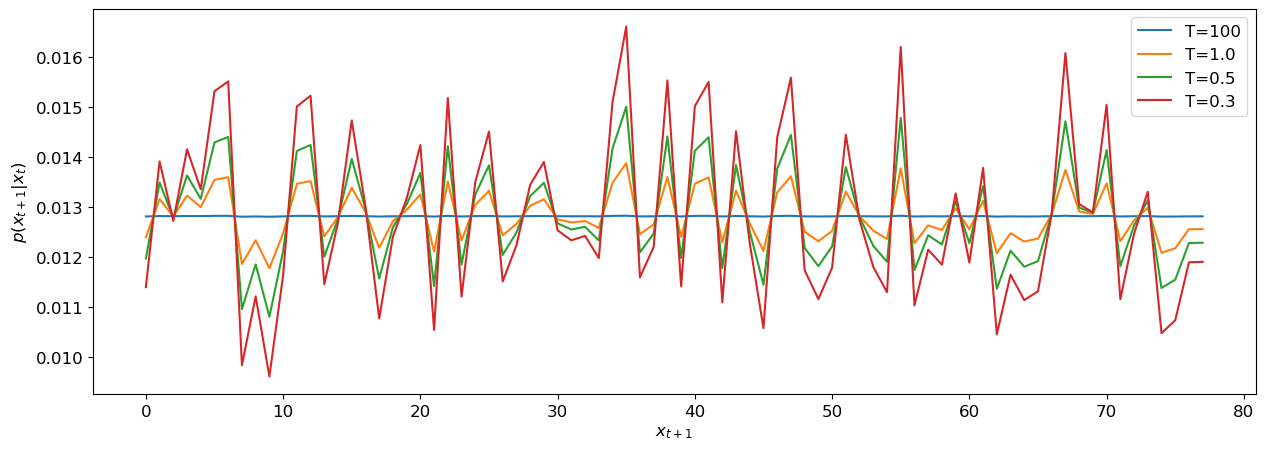

In [24]:
scores = y[0,0,:].detach()
_, ax = plt.subplots(figsize=(15,5))

for t in reversed([0.3, 0.5, 1.0, 100]):
    ax.plot(charnn.hot_softmax(scores, temperature=t).cpu().numpy(), label=f'T={t}')
ax.set_xlabel('$x_{t+1}$')
ax.set_ylabel('$p(x_{t+1}|x_t)$')
ax.legend()

uniform_proba = 1/len(char_to_idx)
uniform_diff = torch.abs(charnn.hot_softmax(scores, temperature=100) - uniform_proba)
test.assertTrue(torch.all(uniform_diff < 1e-4))

In [25]:
for _ in range(3):
    text = charnn.generate_from_model(model, "foobar", 50, (char_to_idx, idx_to_char), T=0.5)
    print(text)
    test.assertEqual(len(text), 50)

foobarT]I&9wh4 i5QXh&YsxGscFHBCVF[EtPCC[SuwTzw'aAE
foobare2j"cFXlOAjxaPHBC"5iXfTKyOa.cC'0kF8 TYFM.R(e
foobar,l)9LgRSX.yZU;b]t-We
Y6rzhLB3kSwwm);IsPxtmcz


### Training
<a id=part1_7></a>

To train this model, I'll calculate the loss at each time step by comparing the predicted char to
the actual char from our label. I can use cross entropy since per char it's similar to a classification problem.
I'll then sum the losses over the sequence and back-propagate the gradients though time.

First, I will try to overfit a large model (many parameters) to a tiny dataset.
To ensure the model and training code are implemented correctly, i.e. that the model can learn.

For a generative model such as this, overfitting is slightly trickier than for classification.
What I'll aim to do is to get our model to memorize a specific sequence of chars, so that when given the first
char in the sequence it will immediately spit out the rest of the sequence verbatim.

In [27]:
# Pick a tiny subset of the dataset
subset_start, subset_end = 1001, 1005
ds_corpus_ss = torch.utils.data.Subset(ds_corpus, range(subset_start, subset_end))
batch_size_ss = 1
sampler_ss = SequenceBatchSampler(ds_corpus_ss, batch_size=batch_size_ss)
dl_corpus_ss = torch.utils.data.DataLoader(ds_corpus_ss, batch_size_ss, sampler=sampler_ss, shuffle=False)

# Convert subset to text
subset_text = ''
for i in range(subset_end - subset_start):
    subset_text += unembed(ds_corpus_ss[i][0])
print(f'Text to "memorize":\n\n{subset_text}')

Text to "memorize":

TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


In [28]:
import torch.nn as nn
import torch.optim as optim
from modules.training import RNNTrainer

torch.manual_seed(43)

lr = 0.01
num_epochs = 500

in_dim = vocab_len
h_dim = 128
n_layers = 2
loss_fn = nn.CrossEntropyLoss()
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

for epoch in range(num_epochs):
    epoch_result = trainer.train_epoch(dl_corpus_ss, verbose=False)
    
    # Every X epochs, we'll generate a sequence starting from the first char in the first sequence
    # to visualize how/if/what the model is learning.
    if epoch == 0 or (epoch+1) % 25 == 0:
        avg_loss = np.mean(epoch_result.losses)
        accuracy = np.mean(epoch_result.accuracy)
        print(f'\nEpoch #{epoch+1}: Avg. loss = {avg_loss:.3f}, Accuracy = {accuracy:.2f}%')
        
        generated_sequence = charnn.generate_from_model(model, subset_text[0],
                                                        seq_len*(subset_end-subset_start),
                                                        (char_to_idx,idx_to_char), T=0.1)
        
        # Stop if we've successfully memorized the small dataset.
        print(generated_sequence)
        if generated_sequence == subset_text:
            break

# Test successful overfitting
test.assertGreater(epoch_result.accuracy, 99)
test.assertEqual(generated_sequence, subset_text)


Epoch #1: Avg. loss = 48.801, Accuracy = 12.89%
Tdwtoouoooooaooomaooooaooooooooooootoooooooooolootooooaooooooooooooooooaooooooooootouoooooooooooooooaoooooaooooooootooooooooooooooooootootoooooooooooooootoooyoooooooooooooooooootoooooooooooooooooioooootooaoooooooooaooooooooooooooooooooooaoooooooooooooooaoo

Epoch #25: Avg. loss = 3.619, Accuracy = 8.20%
TMM.  ,,ssyy.  ,,,ssyy   ,aayA.  aass..  wasa..  E,ssyy.  I,ssry.  ,,asyy.  ,,,ayy.  II,,syy
   saaA.l ,aay.  ,aasy.. ,I,ssyy.  Iaasyy.  ,,asyy.  Easssy.  I,,ssyy
 II,
syy.  ,,,syy
   ,,asyy. I,,ssyy.  ,,asyy
  ,,asyy.  I,,asyy
  aaaA.. aaa..w.o. EIhsyy.. 

Epoch #50: Avg. loss = 1.621, Accuracy = 49.22%
TAM. What haat  ot rtnd  oe  on  sedd  o   oeeee.
   ELLNA.   ttt ie sind  an   ttt eeee.     aat  otrsend   ot tend ssnd   to  eedd  o   oeeee.
   ELLNA.  Sttt reee.     att tt seeed    o wall   ttwwoll  ootwtul  hut haal  oo hatt  ttt  eee.    ELaaA.   S

Epoch #75: Avg. loss = 0.604, Accuracy = 88.67%
TAAM. What would you have?
  HELEN

I'll now train a much larger model on our large dataset. You'll need a GPU for this part.
I'll split our corpus into 90% train and 10% test-set.
Also, I'll use a learning-rate scheduler to control the learning rate during training.

In [31]:
from modules.hyperparams import part1_rnn_hyperparams

hp = part1_rnn_hyperparams()
print('hyperparams:\n', hp)

### Dataset definition
vocab_len = len(char_to_idx)
batch_size = hp['batch_size']
seq_len = hp['seq_len']
train_test_ratio = 0.9
num_samples = (len(corpus) - 1) // seq_len
num_train = int(train_test_ratio * num_samples)

samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)

ds_train = torch.utils.data.TensorDataset(samples[:num_train], labels[:num_train])
sampler_train = SequenceBatchSampler(ds_train, batch_size)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False, sampler=sampler_train, drop_last=True)

ds_test = torch.utils.data.TensorDataset(samples[num_train:], labels[num_train:])
sampler_test = SequenceBatchSampler(ds_test, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, sampler=sampler_test, drop_last=True)

print(f'Train: {len(dl_train):3d} batches, {len(dl_train)*batch_size*seq_len:7d} chars')
print(f'Test:  {len(dl_test):3d} batches, {len(dl_test)*batch_size*seq_len:7d} chars')

### Training definition
in_dim = out_dim = vocab_len
checkpoint_file = 'checkpoints/rnn'
num_epochs = 50
early_stopping = 5

model = charnn.MultilayerGRU(in_dim, hp['h_dim'], out_dim, hp['n_layers'], hp['dropout'])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hp['learn_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=hp['lr_sched_factor'], patience=hp['lr_sched_patience'], verbose=True
)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

hyperparams:
 {'batch_size': 250, 'seq_len': 60, 'h_dim': 1024, 'n_layers': 3, 'dropout': 0.2, 'learn_rate': 0.0001, 'lr_sched_factor': 0.002, 'lr_sched_patience': 5}


c:\Users\27nad\miniconda3\envs\cs3600\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Train: 380 batches, 5700000 chars
Test:   42 batches,  630000 chars


In [32]:
from modules.plot import plot_fit

def post_epoch_fn(epoch, train_res, test_res, verbose):
    # Update learning rate
    scheduler.step(test_res.accuracy)
    # Sample from model to show progress
    if verbose:
        start_seq = "ACT I."
        generated_sequence = charnn.generate_from_model(
            model, start_seq, 100, (char_to_idx,idx_to_char), T=0.5
        )
        print(generated_sequence)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:
        # Print pre-training sampling
        print(charnn.generate_from_model(model, "ACT I.", 100, (char_to_idx,idx_to_char), T=0.5))

        fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=None,
                              post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                              checkpoints=checkpoint_file, print_every=1)
        
        fig, axes = plot_fit(fit_res)
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

ACT I.wmY,qHgy16CvvH8CM6IH0jhv)-'ymrp
:vtYQe]n)qEGX1]QtID5ca;O3PUmwR?WiAvAUi0U86jxXHLfsOlb,?9 WJlXPp
--- EPOCH 1/50 ---
train_batch (23.491):   9%|▉         | 36/380 [13:10<2:05:51, 21.95s/it]

 *** Training interrupted by user


### Generating a work of art
<a id=part1_8></a>

Let's generate the next Hamlet! 

The text I generate looks like a Shakespeare play:
old-style English words and sentence structure, directions for the actors
(like “Exit/Enter”), sections (Act I/Scene III) etc.
There will be no coherent plot of course, but it should at least seem like
a Shakespearean play when not looking too closely.

In [ ]:
from modules.hyperparams import part1_generation_params

start_seq, temperature = part1_generation_params()

generated_sequence = charnn.generate_from_model(
    model, start_seq, 10000, (char_to_idx,idx_to_char), T=temperature
)

print(generated_sequence)